# Modeling the Time Evolution of the Annualized Rate of Mass Shootings with Gaussian Processes
Nathan Sanders
November, 2016

## StanCon 2017


## Abstract

Much of the public policy debate over gun control and gun rights in the United States hinges on the alarming incidence of mass shootings, here defined as attacks killing four or more victims.  Several times in recent years, ndividual, highly salient mass shooting incidents have galvanized public discussion of reform efforts overnight.  But deliberative legislative action proceeds over a much longer timescale.  We have used Stan to develop a new model for the annualized rate of mass shootings in the United States based on a Gaussian process with a time-varying mean function.  This design yields a predictive model with the full non-parametric flexibility of a Gaussian process, while retaining the clear interpretability of a parametric model for long-term evolution of the mass shooting rate.  We apply this model to the Mother Jones database of mass shootings and reach clear conclusions about the long term evolution of the rate of mass shootings in the United States, short-term periods deviating from this trend, and the future consequences of unchecked growth of the rate of mass shootings under this model.

## Background

Tragic, high profile public events over the past few years like the shootings at the Washington Navy Yard; the Charleston Church Shooting; San Bernadino, CA; and Orlando, FL have raised public awareness of the dangers posed by mass shooting events and sociological interest in understanding the motivations and occurrence rates of such events.  A particular question facing elevated public, political, and scholarly scrutiny is whether the rate of mass shootings has increased significantly over recent years.

There is no commonly accepted definition of a mass shooting, but such an event is generally understood to be the simultaneous homicide of multiple people perpetrated by an individual or coordinated group via firearm.  Lott (2014) responded to a [September, 2014 FBI report](https://www.fbi.gov/news/stories/2014/september/fbi-releases-study-on-active-shooter-incidents/pdfs/a-study-of-active-shooter-incidents-in-the-u.s.-between-2000-and-2013) on mass shootings by re-evaluating sources of bias, other data issues, and redefining the period under consideration to conclude that no statistically significant increase is identifiable.  Cohen et al. (2014) claim that the rate of mass shootings tripled over the four year period 2011-2014 based on a Statistical Process Control analysis of duration between successive events.

In this study, we present a new statistical approach to evaluating the time evolution of the rate of mass shootings and making predictions about future change.  We do not present original data on occurrences in the United States, address the myriad considerations inherent in defining a "mass shooting" event, or seek to resolve the issue of whether the growth rate has changed significantly over time, although we do evaluate this claim using a particular and commonly cited mass shooting dataset.

We develop a Gaussian Process-based model for the time evolution of the occurrence rate of mass shootings and demonstrate inference under this model by straightforward application of the probabilistic programming language *Stan*.  We describe the Mother Jones dataset on US mass shootings which we consider in this study and lay out our statistical model and inference scheme.  We discuss the results from this inference and the conclusions that can be reached from inspection of the marginal posterior distributions.

In [114]:
## Notebook setup
%matplotlib inline

import pandas as pd
import numpy as np
import pickle,os
import scipy
from matplotlib import pyplot as plt
from matplotlib import cm
from matplotlib.ticker import FixedLocator
import pystan
from scipy import stats as sstats

%load_ext watermark
%watermark -v -m -p pandas,numpy,scipy,matplotlib

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark
CPython 2.7.6
IPython 4.0.0

pandas 0.18.1
numpy 1.11.2
scipy 0.15.1
matplotlib 1.4.3

compiler   : GCC 4.8.2
system     : Linux
release    : 3.16.0-38-generic
machine    : x86_64
processor  : x86_64
CPU cores  : 4
interpreter: 64bit


## Data

For this study, we consider the [database published by Mother Jones](http://www.motherjones.com/politics/2012/12/mass-shootings-mother-jones-full-data) (retrieved for this study on October 16, 2016}, compiling incidents of mass shootings in the United States from 1982 tgrough September of 2016.  The database includes rich (quantitative and qualitative) metadata on the effects of the incidents, the mental health condition of the perpetrators, weapon type, how the perpetrators obtained their weapons, and more; however, we focus primarily on the dates of incident occurrence.  

The criteria for inclusion in the Mother Jones database were described in a [2014 article by Mark Follman](http://www.motherjones.com/politics/2014/10/mass-shootings-rising-harvard):
	
> [The database] includes attacks in public places with four or more victims killed, a baseline established by the FBI a decade ago. We excluded mass murders in private homes related to domestic violence, as well as shootings tied to gang or other criminal activity.''

Follman discusses their motivations for these criteria and provide some examples of prominent incidents excluded by the criteria, such as the shooting at Ft. Hood in April, 2014.  Our primary dataset is the count of incidents reported in this database per calendar year.  We include incidents labeled as both "Mass" or "Spree" by Mother Jones.  We assume zero mass shootings, by this definition, occurred on years with no reported events in the database.


In [2]:
## Load data
data = pd.read_excel('MotherJonesData_2016_10_16.xlsx','US mass shootings')

## Prepare data
# Aggregate data anually
data_annual = data.groupby('Year')
# Count cases by year and fill in empty years
cases_resamp = data_annual.count().Case.ix[np.arange(1982,2017)].fillna(0)
# Enumerate years in range
data_years = cases_resamp.index.values
# Enumerate quarters across daterange for later plotting
data_years_samp = np.arange(min(data_years), max(data_years)+10, .25)
# Format for Stan
stan_data = {
	'N1': len(cases_resamp),
	'x1': data_years - min(data_years),
	'z1': cases_resamp.values.astype(int),
	'N2': len(data_years_samp),
	'x2': data_years_samp - min(data_years),
	}


In [3]:
for key in stan_data:
    print key
    print stan_data[key]
    print '\n'

x2
[  0.     0.25   0.5    0.75   1.     1.25   1.5    1.75   2.     2.25
   2.5    2.75   3.     3.25   3.5    3.75   4.     4.25   4.5    4.75   5.
   5.25   5.5    5.75   6.     6.25   6.5    6.75   7.     7.25   7.5
   7.75   8.     8.25   8.5    8.75   9.     9.25   9.5    9.75  10.    10.25
  10.5   10.75  11.    11.25  11.5   11.75  12.    12.25  12.5   12.75  13.
  13.25  13.5   13.75  14.    14.25  14.5   14.75  15.    15.25  15.5
  15.75  16.    16.25  16.5   16.75  17.    17.25  17.5   17.75  18.    18.25
  18.5   18.75  19.    19.25  19.5   19.75  20.    20.25  20.5   20.75  21.
  21.25  21.5   21.75  22.    22.25  22.5   22.75  23.    23.25  23.5
  23.75  24.    24.25  24.5   24.75  25.    25.25  25.5   25.75  26.    26.25
  26.5   26.75  27.    27.25  27.5   27.75  28.    28.25  28.5   28.75  29.
  29.25  29.5   29.75  30.    30.25  30.5   30.75  31.    31.25  31.5
  31.75  32.    32.25  32.5   32.75  33.    33.25  33.5   33.75  34.    34.25
  34.5   34.75  35.    35.25  

In [4]:
## Number of years with data
print len(stan_data['x1'])

35


In [5]:
## Number of interpolated points to do prediction for
print len(stan_data['x2'])

176


## Statistical Model

We adopt a univariate Gaussian Process model (see e.g. Rasmussen & Williams 2006) as a non-parametric description of the time evolution of the annualized occurrence rate.  The Gaussian Process describes deviations from a mean function by a covariance matrix that controls the probability of the deviation as a function of the time differential between points.  Robers et al. (2012) surveyed applications of Gaussian Process models to timeseries data, and explored the implications of different choices for the mean and covariance functions.

We adopt the following system of units for the Gaussian Process model.  The time vector $x$ is measured in years since 1982 and the outcome vector $\log(z)$ is defined as the natural logarithm of the number of occurrences.  The logarithmic transformation is a mathematical convenience, so that the mean function regardless of the parameter values for $\mu_0$ and $\mu_b$.

Most applications of Gaussian processes adopt a constant, zero mean function such that all dependence between the dependent variable(s) and the predictors is captured by the non-parametric family of functions defined by the Gaussian process covariance function.  We adopt a linear mean function and a squared-exponential covariance function.  We design the mean and covariance functions to effectively divide the response into a long-term (timescale of decades) parametric effect and a short-term (timescale of years) non-parametric effect.  This approach gives us the full flexibility of the Gaussian process for predictive applications, which still allowing us to make interpretable inferences on the long-term evolution of the system.  

The mean function $m(x)$ is simply:
	
\begin{equation}
\mu(x) = \mu_0 + m_b~x
\end{equation}

Note that the linear mean function for the outcome variable $\log(z)$ corresponds to an exponential function for the evolution of the number of shootings per year.  

The familiar squared-exponential covariance function, which generates infinitely-differentiable functions from the Gaussian Process, is:

\begin{equation}
k(x)_{i,j} = \eta^2~exp \big( -\rho^2 \sum_{d=1}^{D}(x_{i,d} - x_{j,d})^2 \big) + \delta_{i,j}~\sigma^2
\end{equation}

where the hyperparameter $\eta$ controls the overall strength of covariance, $\rho$ controls the timescale over which functions drawn from the process vary, and $\sigma$ controls the baseline level of variance.

Our likelihood assumes that the logarithmic occurrence rate is specified by exponentiated draws of the occurrence rate $y$ from the mean and covariance functions, and the observed outcome data is negative binomial-distributed according to the rate.

\begin{align}
y(x) \sim \rm{N}(\mu(x), k(x)^2) \\
\log\big(z(x)\big) ~ \sim \rm{NB}(exp(y(x)), \phi)
\end{align}

where $\rm{N}$ is the normal (parameterized by the standard deviation rather than the variance) and $\rm{NB}$ is the negative binomial distribution.  We use the "alternative" parameterization of the negative binomial distribution described in the Stan manual, where the second parameter directly scales the overdispersion relative to a Poisson distribution.  While we choose the negative binomial to permit overdispersion in the annualized mass shooting rate beyond counting noise, as we will see, the data provide strong evidence for small values of $\phi^{-1}$, consistent with Poisson noise.

We apply the following prior and hyperprior distributions to provide weak information about the scale of the relevant parameters in the adopted unit system:

\begin{align*}
\eta^2 \sim \rm{C}(2. 5) \\
\rho^{-1} \sim \Gamma(4, 1)  \\
\sigma^2 \sim \rm{C}(0. 2.5)  \\
\mu_0 \sim \rm{N}(0, 2)  \\
\mu_b \sim \rm{N}(0, 0.2)  \\
\phi^{-1} \sim C(0, 0.5)
\end{align*}

where $\Gamma$ is the gamma distribution; $\rm{C}$ is the half-Cauchy distribution; the parameters $\eta^2$, $\sigma^2$, and $\phi^{-1}$ are constrained to be positive; and we apply the constraint $\rho^{-1} > 1$ to enforce timescales $>1$~year.

We implement the Gaussian Process model in *Stan*, adapting the logistic classification example in Section 14.5 of the *Stan* manual.  *Stan's* *NUTS* sampler performs full joint Bayesian estimation of all parameters, including the mean function parameters $\mu_0$ and $\mu_b$ and the Gaussian Process hyperparmeters $\eta$, $\rho$, and $\sigma$ and the negative binomial over-dispersion $\phi^{-1}$.  We use the Cholesky factor transformed implementation of the normal distribution to calculate the likelihood. 

Because the presence of the highly-correlated and poorly-identified hyperparameters introduces significant curvature in the model posterior, HMC is a particularly effective sampling strategy for this model (Betancourt & Girolami 2013).  Nonetheless, there is a significant computational burden for adapting the *NUTS* sampler and generating a sufficient number of samples from the posterior to do conclusive inference.  We fit the model to the 35 annual observations of the Mother Jones dataset and do model interpolation and prediction over a grid of 176 quarters from 1980 to 2024.  We fit 8 independent chains of length 1000 iterations (following an equal number of NUTS warmup samples) in parallel using *Stan* and observe a typical execution time of ~1 hr.  


In [6]:
## Full model in Stan code:
stan_code = """
data {
	int<lower=1> N1;
	vector[N1] x1;
	int z1[N1];
	int<lower=1> N2;
	vector[N2] x2;
}
transformed data {
	int<lower=1> N;
	vector[N1+N2] x;
	N = N1 + N2;
	for (n in 1:N1) x[n] = x1[n];
	for (n in 1:N2) x[N1 + n] = x2[n];
}
parameters {
	vector[N1] y1;
	vector[N2] y2;
	real<lower=0> eta_sq;
	real<lower=1> inv_rho;
	real<lower=1e-6> sigma_sq;
	real mu_0;
	real mu_b;
	real<lower=0> NB_phi_inv;
}
model {
	matrix[N,N] Sigma;
	vector[N] y;
	matrix[N1+N2,N1+N2] L;
	vector[N1+N2] mu;
	
	// Calculate mean function
	for (i in 1:N) mu[i] = mu_0 + mu_b * x[i];

	// off-diagonal elements
	for (i in 1:(N-1)) {
		for (j in (i+1):N) {
			Sigma[i,j] = eta_sq * exp(-pow(inv_rho,-2) * pow(x[i] - x[j],2));
			Sigma[j,i] = Sigma[i,j];
		}
	}
	// diagonal elements
	for (k in 1:N)
		Sigma[k,k] = eta_sq + sigma_sq;
	
	// Decompose
	L = cholesky_decompose(Sigma);
	
	// GP hyperpriors
	eta_sq ~ cauchy(0, 1);
	sigma_sq ~ cauchy(0, 1);
	inv_rho ~ gamma(4, 1); // Gamma prior with mean of 4 and std of 2
    
	// Mean model priors
	mu_0 ~ normal(0, 2);
	mu_b ~ normal(0, 0.2);
	
	// Negative-binomial prior
	NB_phi_inv ~ cauchy(0, 0.5);
	
	// Parameter sampling
	for (n in 1:N1) y[n] = y1[n];
	for (n in 1:N2) y[N1 + n] = y2[n];
	y ~ multi_normal_cholesky(mu, L);
	
	// Likelihood
	for (n in 1:N1) {
		z1[n] ~ neg_binomial_2(exp(y1[n]), inv(NB_phi_inv));
	}
}
"""

## Model fitting


In [7]:
## Compile
#stan_model_compiled = pystan.StanModel(model_code=stan_code)

In [8]:
## Sampling
Nchains = 8
Niter = 2000
cdic = {'max_treedepth': 15}
#stan_model_samp = stan_model_compiled.sampling(data = stan_data, iter=Niter, chains=Nchains, control=cdic)

In [9]:
## Sampling takes ~1 hr on .  For convenience, we provide a pre-sampled results.
#stan_model_ext = stan_model_samp.extract()
#with open('stan_model_ext.p','w') as f: pickle.dump(stan_model_ext,f)

with open('stan_model_ext.p','r') as f: stan_model_ext = pickle.load(f)

The MCMC trace illustrates the high independence of samples achieved after the *NUTS* algorithm warm-up period, and the low variance in sampling distributions between chains.  


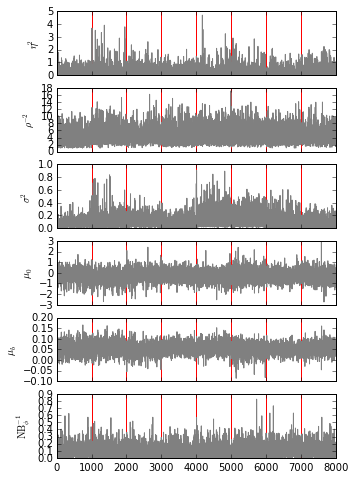

In [12]:
## Traceplot
trace_pars = [('eta_sq','$\\eta^2$'),
	      ('inv_rho','$\\rho^{-2}$'),
	      ('sigma_sq','$\\sigma^2$'),
	      ('mu_0','$\\mu_0$'),
	      ('mu_b','$\\mu_b$'),
	      ('NB_phi_inv','$\\rm{NB}_\\phi^{-1}$')]
fig,axs = plt.subplots(len(trace_pars), figsize=(5,8), sharex='all')
for i,par in enumerate(trace_pars):
	axs[i].plot(stan_model_ext[par[0]], color='.5')
	axs[i].set_ylabel(par[1])
	for j in range(1, Nchains):
		axs[i].axvline(Niter/2 * j, c='r', zorder=-1)


The Gelman-Rubin convergence diagnostic, $\hat{R}$, a comparison of  within- to between-chain variance.

*Note: Visualization currently not working from pickled model results; need to fix.*


In [22]:
model_summary = stan_model_samp.summary()
Rhat_vec = model_summary['summary'][:,array(model_summary['summary_colnames'])=='Rhat']
pars = model_summary['summary_rownames']
## Replace y1, y2 with summaries
sel_pars = ['y1', 'y2', u'eta_sq', u'inv_rho', u'sigma_sq', u'mu_0', u'mu_b']
Rhat_dic = {}
for spar in sel_pars:
	if spar in ('y1','y2'):
		sel = array([True if p.startswith(spar) else False for p in pars])
		Rhat_dic[spar] = percentile(Rhat_vec[sel], [5,50,95])
	else:
		Rhat_dic[spar] = [Rhat_vec[[pars==spar]][0][0],]*3

plt.figure(figsize=(5,6))
plt.errorbar(array(Rhat_dic.values())[:,1], arange(len(sel_pars)), \
	xerr= [array(Rhat_dic.values())[:,1] - array(Rhat_dic.values())[:,0],\
		array(Rhat_dic.values())[:,2] - array(Rhat_dic.values())[:,1]],\
	capsize=0, marker='o', color='k', lw=0, elinewidth=1)
plt.yticks(arange(len(sel_pars)), Rhat_dic.keys(), size=11)
plt.xlabel('$\hat{R}$')
plt.axvline(1.05, color='.5', ls='dashed', zorder=-2)
plt.ylim(-1, len(sel_pars))

NameError: name 'stan_model_samp' is not defined

## Posterior Predictive Checks

To assess goodness of fit, we perform posterior predictive checks.

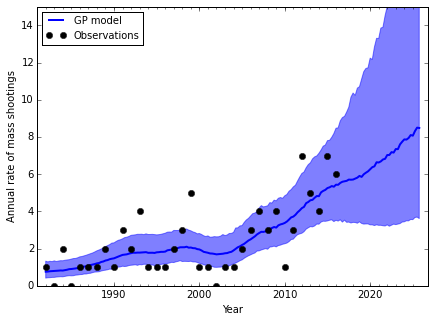

In [118]:
def plot_PPC():
    y2_sum = np.percentile(np.exp(stan_model_ext['y2']), [16,50,84], axis=0)
    plt.figure(figsize=(7,5))
    pfb = plt.fill_between(data_years_samp, y2_sum[0], y2_sum[2], color='b', alpha=.5)
    pfg = plt.plot(data_years_samp, y2_sum[1], c='b', lw=2, label='GP model', zorder=0)
    po = plt.plot(data_years, stan_data['z1'], 'o', c='k', label='Observations', zorder=2)
    plt.xlabel('Year')
    plt.ylabel('Annual rate of mass shootings')
    plt.legend(prop={'size':10}, loc=2)
    plt.ylim(0,15)
    plt.gca().xaxis.set_minor_locator(FixedLocator(np.arange(min(data_years_samp), max(data_years_samp))))
    plt.gca().set_xlim(min(data_years_samp) - 1, max(data_years_samp) + 1)
    return pfb, pfg, po

pfb, pfg, po = plot_PPC()

The model does not show any visually apparent deviations from the evolution of the observational time series, although comparison to the data highlights several years with substantially outlying mass shooting totals (e.g. 1993 and 1999).

We can add random draws from the mean function to visualize our inferences on the long-term time evolution of the mass shooting rate.

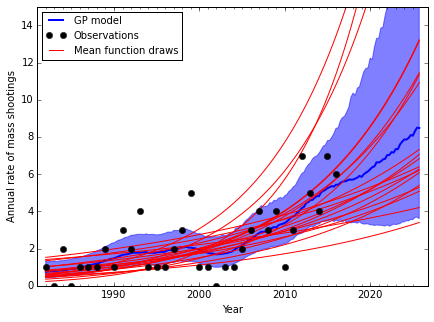

In [123]:
plot_PPC()
N_samp = len(stan_model_ext['mu_0'])
px = np.linspace(min(data_years_samp), max(data_years_samp), 100) 
pfms = []
for i in range(20):
	draw = np.random.randint(0, N_samp)
	py = np.exp(stan_model_ext['mu_0'][draw] + (px - min(data_years)) * stan_model_ext['mu_b'][draw])
	pfms.append(plt.plot(px, py,  c='r', 
	  zorder = 1, label = 'Mean function draws' if i==0 else None))
plt.legend(prop={'size':10}, loc=2)


The comparison between the fitted mean functions (red) and the model posterior (blue) suggests that there was a significant dip in the annualized rate of mass shootings in the years from about 2000 to 2005.  The model has no features that would seek to explain the causal origin of this dip, although many readers may be surprised by its juxtoposition with the Columbine High School massacre (1999), which is known to have spawned dozenss of "copycat" attacks (see e.g. Follman & Andrews 2015).

Next we add random draws from the Gaussian process itself to visualize how the Gaussian process models short term variation in the rate.

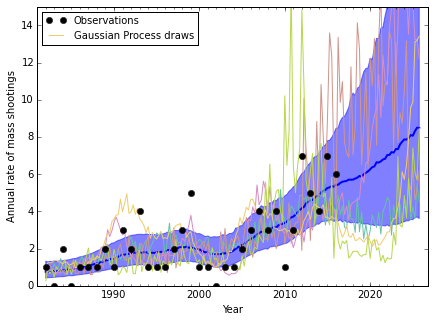

In [120]:
pfb, pfg, po = plot_PPC()
N_draws = 5
for i in range(N_draws):
	draw = np.random.randint(0, N_samp)
	py = np.exp(stan_model_ext['y2'][draw])
	pfgd = plt.plot(data_years_samp, py,  c=cm.Set2(i / float(N_draws)), 
	  zorder = 1)
plt.legend([po[0], pfgd[0]], ['Observations', 'Gaussian Process draws'], prop={'size':10}, loc=2)


## Parameter inferences

Below we show the marginalized posterior distributions of the mean function parameters.  


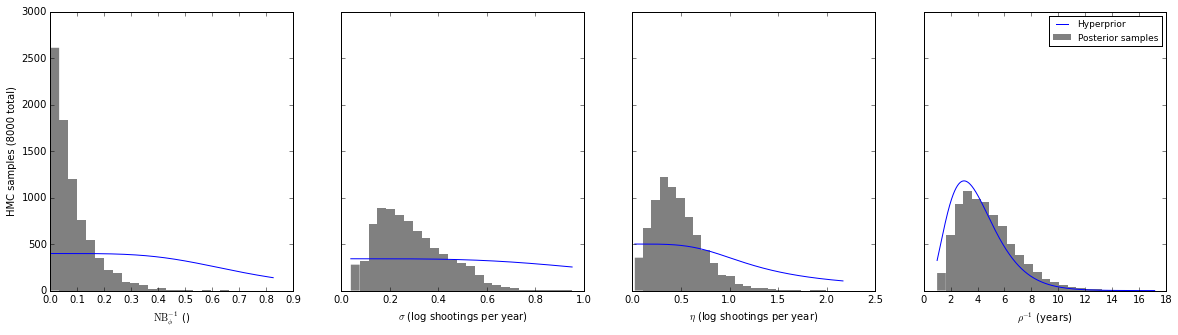

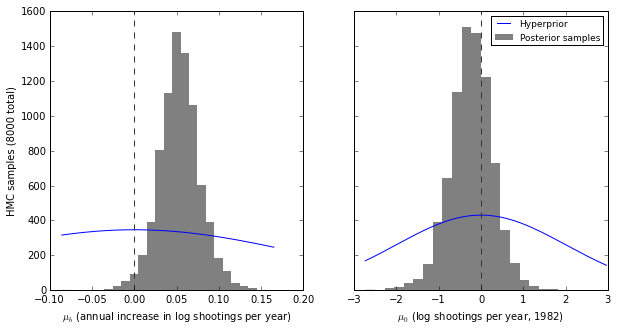

In [127]:
def gt0(y, x, lbound=0, ubound=np.inf):
	y[(x<lbound) & (x>ubound)] = 0
	return y

hyp_dic = {
	'eta_sq': ('$\\eta$', np.sqrt, 'log shootings per year', lambda x: sstats.cauchy.pdf(x**2, 0, 1)),
	#'inv_rho': ('$\\rho^{-1}$', lambda x: x, 'years', lambda x: gt0(sstats.norm.pdf(x, 10, 5), x, lbound=1)),
	'inv_rho': ('$\\rho^{-1}$', lambda x: x, 'years', lambda x: gt0(sstats.gamma.pdf(x, 4, scale=1), x, lbound=1)),
	'sigma_sq': ('$\\sigma$', np.sqrt, 'log shootings per year', lambda x: sstats.cauchy.pdf(x**2, 0, 1)),
	'NB_phi_inv':('$\\rm{NB}_\\phi^{-1}$', lambda x:x, '', lambda x: sstats.cauchy.pdf(x**2, 0, 0.5)),
	}

meanfunc_dic = {
	'mu_0': ('$\\mu_0$', lambda x: x, 'log shootings per year, '+str(np.min(data_years)), lambda x: sstats.norm.pdf(x, 0,2)),
	'mu_b': ('$\\mu_b$', lambda x: x, 'annual increase in log shootings per year', lambda x: sstats.norm.pdf(x, 0,0.2)),
	}

for name,pdic in (('hyper', hyp_dic), ('meanfunc', meanfunc_dic)):
	fig,axs = plt.subplots(1,len(pdic), figsize=(5*len(pdic), 5), sharey='all')
	axs[0].set_ylabel('HMC samples ({} total)'.format(N_samp))
	for i,hyp in enumerate(pdic.keys()):
		samps = pdic[hyp][1](stan_model_ext[hyp])
		hn, hb, hp = axs[i].hist(samps, 25, edgecolor='none', facecolor='.5', label='Posterior samples')
		ppx = np.linspace(np.min(samps), np.max(samps), 10000)
		ppy = pdic[hyp][1]( pdic[hyp][3](ppx) )
		## Normalize
		#ppy *= np.percentile(hn, 80) / np.max(ppy)
		ppy *= len(samps) / np.sum(ppy) * len(ppy) / len(hn)
		axs[i].plot(ppx, ppy, color='b', zorder=2, label='Hyperprior')
		axs[i].set_xlabel(pdic[hyp][0] + ' ({})'.format(pdic[hyp][2]))
		axs[i].axvline(0, ls='dashed', color='.2')
	axs[-1].legend(prop={'size':9})



The comparison of the posterior and prior distributions show strong evidence from the data for most parameters, with $\rho^{-1}$ being a notable exception.  For example, the posterior for $\mu_0$ shows a concentration around a baseline rate of $\exp(-1)\sim0.4$ to $\exp(1)\sim 3$ mass shootings per year at the start of the dataset, 1982.

We calculate the posterior probability that the annualized rate of mass shootings has increased in the US since 1982 ($\mu_b > 0$).

In [44]:
print '%0.0f'%(np.mean(stan_model_ext['mu_b'] > 0)*100)+'%'

98%


This indicates strong statistical evidence for a long term increase in the annualized rate of mass shoortings over the past three decades.  In linear terms, the mean percentage increase in the rate of mass shootings is found to be,

In [75]:
zincreaseraw = (np.exp((2016 - np.min(data_years)) * stan_model_ext['mu_b']) - 1) * 100
zincrease = np.percentile(zincreaseraw, [16,50,84])
print '%0.0f'%zincrease[1]+'^{+%0.0f'%(zincrease[2]-zincrease[1])+'}_{-%0.0f'%(zincrease[1]-zincrease[0])+'}'


510^{+708}_{-320}


While the uncertainty interval is large, the $1\sigma$ estimate suggests at least a tripling in the annualized rate of mass shootings over these three decades.

For comparison, the US population has grown from $\sim231$ million to $318$ million residents according to [worldbook data](http://data.worldbank.org/indicator/SP.POP.TOTL?cid=GPD_1), an increase of $38\%$, over that same period.  The model posterior suggests that the rate of mass shootings has surpassed the rate of population growth with high confidence:

In [80]:
print '%0.0f'%(np.mean(zincreaseraw > 38)*100)+'%'

97%


The extrapolatory value of this model is limited because our linear parameterization of the mean function admits no opportunity for the long term rate of increase in mass shootings to decline over time.  We certainly hope that cultural and policy changes in the United States will alter the course of long term evolution of the shooting rate as soon as possible.  Accepting this limitation of the parameterized mean function, extrapolation under this model suggests annual rates of mass shootings between about 4 and 20 per year in the US in the year 2026.


In [83]:
print int(np.ceil(np.max(data_years_samp)))
zfinal = np.percentile(np.exp(stan_model_ext['y2'][:,-1]), [16,50,84])
print '%0.1f'%zfinal[1]+'^{+%0.1f'%(zfinal[2]-zfinal[1])+'}_{-%0.1f'%(zfinal[1]-zfinal[0])+'}'

2026
8.5^{+11.5}_{-4.9}


As an independent estimate, Cohen et al. (2014) claimed a tripling in the rate of mass shottings between 2011 and 2014.  Our inference on the mean function of the Gaussian process, because it is parameterized as linear over the full time extent of the modeled period, does not directly address this claim.  But the simulated predictions of the Gaussian process can generate relevant comparisons.

Probability of increase:  71 %
Mean factor of predicted increase:  1.5 X
Probability of increase by at least 3X:  0.1 %


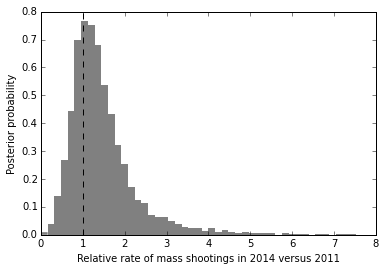

In [108]:
i1 = np.argmin(abs(data_years_samp - 2011.5))
i2 = np.argmin(abs(data_years_samp - 2014.5))
py = np.exp(stan_model_ext['y2'][:,i2]) / np.exp(stan_model_ext['y2'][:,i1])

plt.figure()
ph = plt.hist(py, 50, edgecolor='none', facecolor='.5', range=[0,8], normed=1)
plt.xlabel('Relative rate of mass shootings in 2014 versus 2011')
plt.ylabel('Posterior probability')
plt.axvline(1, color='k', ls='dashed')

print "Probability of increase: ", '%0.0f'%(np.mean(py > 1) * 100), '%'
print "Mean factor of predicted increase: ", '%0.1f'%(np.mean(py)), 'X'
print "Probability of increase by at least 3X: ", '%0.1f'%(np.mean(py > 3)), '%'

While we find that the increase in the rate of mass shootings over the past three decades is likely to be a factor of several, we find much less evidence for such a dramatic increase over the time period from 2011 to 2014.  As reported above, our model predicts better than even odds that there was an increase during that three year period, but the odds that it was as high as a tripling are exceedingly small.  The increase was more likely to be $\sim50\%$.

## Conclusions

We have used Stan to implement and estimate a new negative binomial regression model for the annualized rate of mass shootings in the United States based on a Gaussian process model with a time-varying mean function.  This design yields a predictive model with the full non-parametric flexibility of a Gaussian process, while retaining the clear interpretability of a parametric model by isolating and jointly modeling long-term (timescale of decades) evolution in the shooting rate.  Applying this model to the Mother Jones database of US mass shootings, our major conclusions are as follows,

* We use posterior predictive checks to demonstrate the efficacy of the Gaussian process model in predicting the annual mass shooting rate.
* We use the non-parametric Gaussian process predictive model to identify an apparent dip in the mass shooting rate in the first few years of the new millenium.
* With a 98% probability, we find that the annualized rate of mass shootings has risen over the past three decades
* The posterior mean estimate for the increase in the shooting rate since 1982 is $\sim500\%$.
* While we sincerely hope that cultural and policy changes will lead to a change in the long term evolution of the mass shooting rate, extrapolating from the present trend would yield a rate of $\sim5-11$ mass shootings per year one decade from now.
* We compare to an independent, 2014 analysis of the increase in the rate of mass shootings between 2011 and 2014 and do not find evidence to support the extreme, 200% rate of increase reported at that time.  Instead we find a smaller, but still deeply troubling, rate of increase closer to 50% over that 4 year period.

## References
* Betancourt & Girolami 2013: Michael Betancourt &  Mark Girolami 2013, [Hamiltonian Monte Carlo for Hierarchical Models](https://arxiv.org/abs/1312.0906)
* Cohen et al. 2014: Amy Cohen et al. 2014, [Rate of Mass Shootings Has Tripled Since 2011, Harvard Research Shows](http://www.motherjones.com/politics/2014/10/mass-shootings-increasing-harvard-research)
* Follman & Andrews 2015: Mark Follman and Becca Andrews 2015, [How Columbine Spawned Dozens of Copycats](http://www.motherjones.com/politics/2015/10/columbine-effect-mass-shootings-copycat-data)
* Lott 2014: John R. Lott 2014, [The FBI's Misrepresentation of the Change in Mass Public Shootings](http://dx.doi.org/10.2139/ssrn.2524731)
* Rasmussen & Williams 2006: Carl Edward Rasmussen & CKI Williams 2006, [Gaussian processes for machine learning](http://www.gaussianprocess.org/gpml/)
* Roberts et al. 2012: S. Roberts et al 2012, [Gaussian processes for time-series modelling](http://www.robots.ox.ac.uk/~sjrob/Pubs/Phil.%20Trans.%20R.%20Soc.%20A-2013-Roberts-.pdf)
* *Stan* Manual: [Stan Modeling Language Users Guide and Reference Manual](http://mc-stan.org/), Version 2.8.0